IMPORT LIBRARIES

In [41]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop, Adam
print(keras.__version__)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
font = {'family':'arial', 'style':'normal', 'size':18}
axis_font = {'family':'arial', 'style':'normal', 'size':18}
plt.rc('font', **font)

2.14.0


LOAD DATA

In [42]:
dataset_weather = pd.read_csv('Weather.csv', header=0, index_col=0)
dataset_climate = pd.read_csv('GreenhouseClimate.csv', header=0, index_col=0)
df_weather = pd.read_csv('Weather.csv')
df_climate = pd.read_csv('GreenhouseClimate.csv', low_memory=False)
print(df_weather.columns)
print(df_climate.columns)


C:\Users\kekop\AppData\Local\Temp\ipykernel_22680\1739820047.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_climate = pd.read_csv('GreenhouseClimate.csv', header=0, index_col=0)


Index(['%time', 'dt', 'AbsHumOut', 'Iglob', 'PARout', 'Pyrgeo', 'RadSum',
       'Rain', 'Rhout', 'Tout', 'Winddir', 'Windsp'],
      dtype='object')
Index(['%time', 'AssimLight', 'BlackScr', 'CO2air', 'Cum_irr', 'EC_drain_PC',
       'EnScr', 'HumDef', 'PipeGrow', 'PipeLow', 'Rhair', 'Tair', 'Tot_PAR',
       'Tot_PAR_Lamps', 'VentLee', 'Ventwind', 'assim_sp', 'assim_vip',
       'co2_dos', 'co2_sp', 'co2_vip', 'dx_sp', 'dx_vip', 'int_blue_sp',
       'int_blue_vip', 'int_farred_sp', 'int_farred_vip', 'int_red_sp',
       'int_red_vip', 'int_white_sp', 'int_white_vip', 'pH_drain_PC',
       'scr_blck_sp', 'scr_blck_vip', 'scr_enrg_sp', 'scr_enrg_vip',
       't_grow_min_sp', 't_grow_min_vip', 't_heat_sp', 't_heat_vip',
       't_rail_min_sp', 't_rail_min_vip', 't_vent_sp', 't_ventlee_vip',
       't_ventwind_vip', 'water_sup', 'water_sup_intervals_sp_min',
       'water_sup_intervals_vip_min', 'window_pos_lee_sp',
       'window_pos_lee_vip'],
      dtype='object')


In [43]:
df = pd.concat(
[
df_weather["%time"],
df_weather["dt"],
df_weather["Tout"],
df_weather["Rhout"],
df_weather["Iglob"],
df_weather["Windsp"],
df_climate["Tair"],
df_climate["Rhair"],
df_climate["CO2air"]
],
axis=1,
)
print(df.shape)
df

(47809, 9)


,%time,dt,Tout,Rhout,Iglob,Windsp,Tair,Rhair,CO2air
0,43815.00000,12/16/2019 0:00,6.9,80.6,0.0,4.7,21.0,51.9,509
1,43815.00347,12/16/2019 0:05,6.9,80.6,0.0,4.7,21.5,51.3,484
2,43815.00694,12/16/2019 0:10,6.9,80.4,0.0,4.7,21.6,52.2,475
3,43815.01042,12/16/2019 0:15,6.9,80.2,0.0,4.7,21.3,54.6,501
4,43815.01389,12/16/2019 0:20,6.7,80.9,0.0,4.7,21.4,54.4,487
...,...,...,...,...,...,...,...,...,...
47804,43980.98611,5/29/2020 23:40,15.1,71.4,0.0,4.3,18.0,86.1,479
47805,43980.98958,5/29/2020 23:45,15.0,71.5,0.0,4.3,17.9,86.5,485
47806,43980.99306,5/29/2020 23:50,15.0,70.8,0.0,3.8,17.9,86.9,465
47807,43980.99653,5/29/2020 23:55,15.0,71.0,0.0,3.8,17.9,87.2,470


PREPROCESS DATA

In [44]:
df = df.dropna().reset_index(drop=True)
df['dt'] = pd.to_datetime(df["dt"])
df.iloc[:,2:]=df.iloc[:,2:].apply(pd.to_numeric)
df

,%time,dt,Tout,Rhout,Iglob,Windsp,Tair,Rhair,CO2air
0,43815.00000,2019-12-16 00:00:00,6.9,80.6,0.0,4.7,21.0,51.9,509
1,43815.00347,2019-12-16 00:05:00,6.9,80.6,0.0,4.7,21.5,51.3,484
2,43815.00694,2019-12-16 00:10:00,6.9,80.4,0.0,4.7,21.6,52.2,475
3,43815.01042,2019-12-16 00:15:00,6.9,80.2,0.0,4.7,21.3,54.6,501
4,43815.01389,2019-12-16 00:20:00,6.7,80.9,0.0,4.7,21.4,54.4,487
...,...,...,...,...,...,...,...,...,...
47733,43980.98264,2020-05-29 23:35:00,15.2,71.8,0.0,4.3,18.0,85.6,459
47734,43980.98611,2020-05-29 23:40:00,15.1,71.4,0.0,4.3,18.0,86.1,479
47735,43980.98958,2020-05-29 23:45:00,15.0,71.5,0.0,4.3,17.9,86.5,485
47736,43980.99306,2020-05-29 23:50:00,15.0,70.8,0.0,3.8,17.9,86.9,465


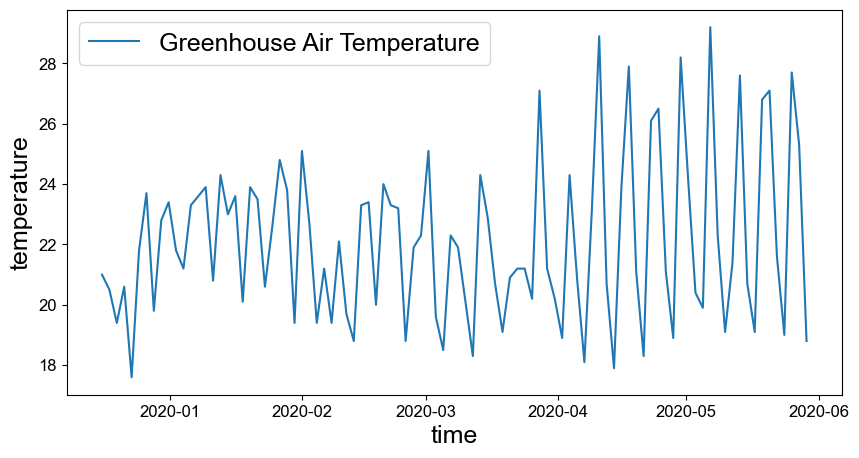

In [45]:
# fig = plt.figure(figsize=(10, 5))
# plt.plot(df["dt"].iloc[::500], df["Tair"].iloc[::500], label='Greenhose Air plt.xlabel("time", axis_font)')
# plt.ylabel("temperature", axis_font)
# plt.legend()
# plt.show()

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
plt.plot(df["dt"].iloc[::500], df["Tair"].iloc[::500], label='Greenhouse Air Temperature')
plt.xlabel("time", fontsize=18)
plt.ylabel("temperature", fontsize=18)
plt.legend()
plt.show()


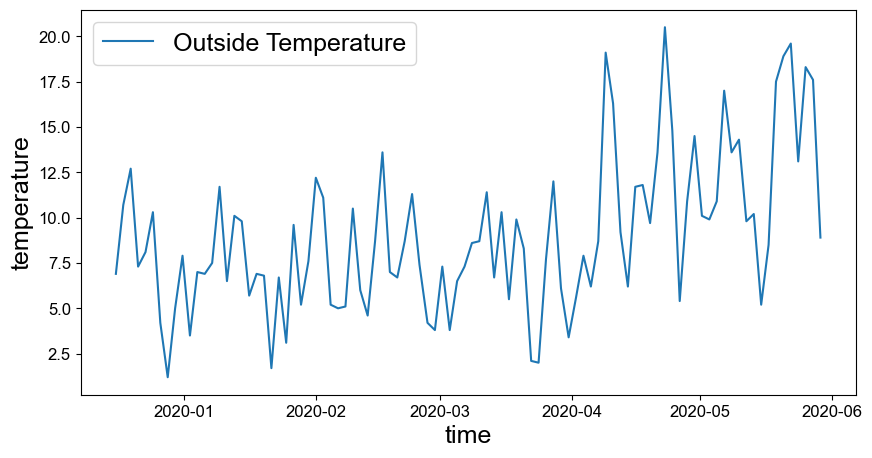

In [46]:
fig = plt.figure(figsize=(10, 5))
plt.plot(df["dt"].iloc[::500], df["Tout"].iloc[::500], label='Outside Temperature')
plt.xlabel("time", axis_font)
plt.ylabel("temperature", axis_font)
plt.legend()

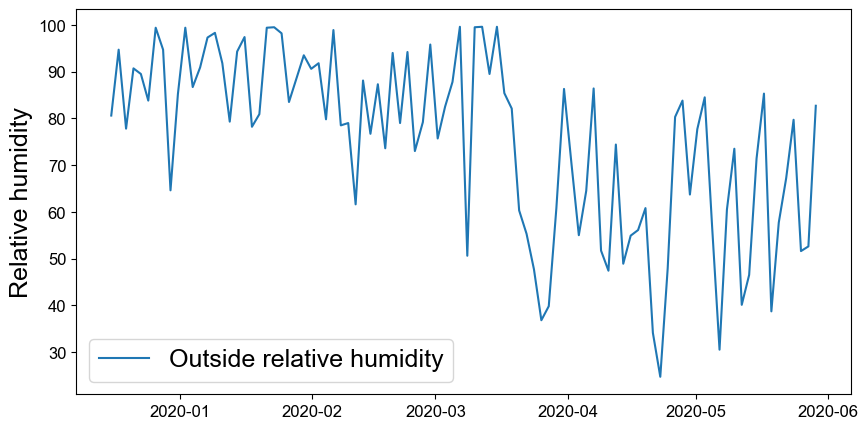

In [47]:
fig = plt.figure(figsize=(10, 5))
plt.plot(df["dt"].iloc[::500], df["Rhout"].iloc[::500], label='Outside relative humidity')
plt.ylabel("Relative humidity", axis_font)
plt.legend()

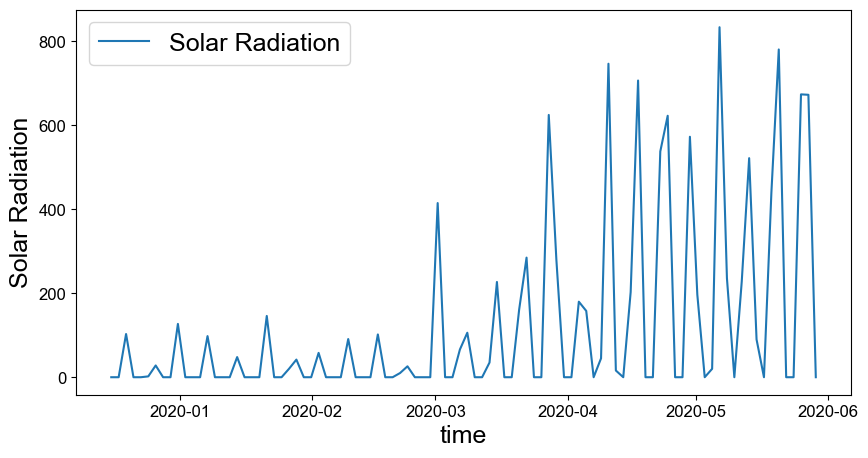

In [48]:
fig = plt.figure(figsize=(10, 5))
plt.plot(df["dt"].iloc[::500], df["Iglob"].iloc[::500], label='Solar Radiation')
plt.xlabel("time", axis_font)
plt.ylabel("Solar Radiation", axis_font)
plt.legend()

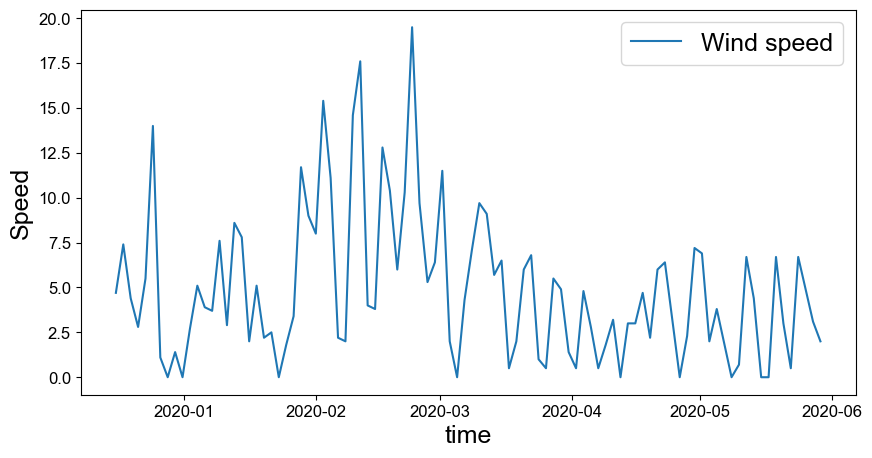

In [49]:
fig = plt.figure(figsize=(10, 5))
plt.plot(df["dt"].iloc[::500], df["Windsp"].iloc[::500], label='Wind speed')
plt.xlabel("time", axis_font)
plt.ylabel("Speed", axis_font)
plt.legend()

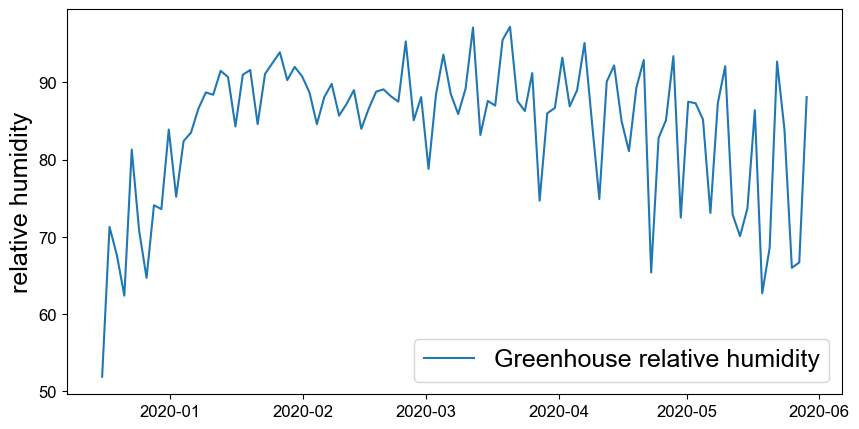

In [50]:
fig = plt.figure(figsize=(10, 5))
plt.plot(df["dt"].iloc[::500], df["Rhair"].iloc[::500], label='Greenhouse relative humidity')
plt.ylabel("relative humidity", axis_font)
plt.legend()

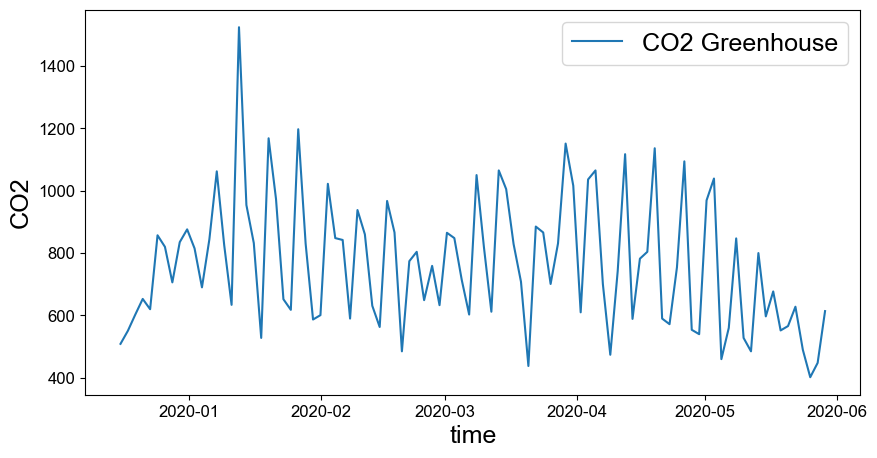

In [51]:
fig = plt.figure(figsize=(10, 5))
plt.plot(df["dt"].iloc[::500], df["CO2air"].iloc[::500], label='CO2 Greenhouse')
plt.xlabel("time", axis_font)
plt.ylabel("CO2", axis_font)
plt.legend()

In [52]:
# n_train = int(df.shape[0] * 0.6)
# n_val = int(df.shape[0] * 0.2)
# df_normalized = df.copy()
# df_normalized.iloc[:,2:] = df.iloc[:,2:].apply(lambda x: (x-x.iloc))
# df_normalized

n_train = int(df.shape[0] * 0.6)
n_val = int(df.shape[0] * 0.2)
df_normalized = df.copy()
df_normalized.iloc[:,2:] = df.iloc[:,2:].apply(lambda x: (x-x.iloc[:n_train].mean())/x.iloc[:n_train].std(), axis=0)
df_normalized


,%time,dt,Tout,Rhout,Iglob,Windsp,Tair,Rhair,CO2air
0,43815.00000,2019-12-16 00:00:00,-0.133117,-0.336538,-0.457518,-0.309241,-0.256191,-4.370155,-1.645954
1,43815.00347,2019-12-16 00:05:00,-0.133117,-0.336538,-0.457518,-0.309241,-0.044735,-4.448084,-1.789053
2,43815.00694,2019-12-16 00:10:00,-0.133117,-0.351280,-0.457518,-0.309241,-0.002444,-4.331191,-1.840568
3,43815.01042,2019-12-16 00:15:00,-0.133117,-0.366022,-0.457518,-0.309241,-0.129317,-4.019475,-1.691746
4,43815.01389,2019-12-16 00:20:00,-0.210349,-0.314424,-0.457518,-0.309241,-0.087026,-4.045452,-1.771881
...,...,...,...,...,...,...,...,...,...
47733,43980.98264,2020-05-29 23:35:00,3.072010,-0.985190,-0.457518,-0.405498,-1.524929,0.00685,-1.932151
47734,43980.98611,2020-05-29 23:40:00,3.033394,-1.014674,-0.457518,-0.405498,-1.524929,0.071791,-1.817672
47735,43980.98958,2020-05-29 23:45:00,2.994778,-1.007303,-0.457518,-0.405498,-1.56722,0.123743,-1.783329
47736,43980.99306,2020-05-29 23:50:00,2.994778,-1.058901,-0.457518,-0.525820,-1.56722,0.175696,-1.897807


In [53]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    index_column_temp = df_normalized.columns.get_loc("Tair") - 2
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][index_column_temp]
        yield samples, targets


In [54]:
lookback = 1440
step = 10
delay = 144
batch_size = 128
array_normalized = df_normalized.iloc[:, 2:].to_numpy()

def get_generators():
    train_gen = generator(array_normalized,
                          lookback=lookback,
                          delay=delay,
                          min_index=0,
                          max_index=n_train,
                          shuffle=False,
                          step=step,
                          batch_size=batch_size)
    
    val_gen = generator(array_normalized,
                        lookback=lookback,
                        delay=delay,
                        min_index=n_train + 1,
                        max_index=n_train + n_val,
                        step=step,
                        batch_size=batch_size)
    
    test_gen = generator(array_normalized,
                         lookback=lookback,
                         delay=delay,
                         min_index=n_train + n_val + 1,
                         max_index=None,
                         step=step,
                         batch_size=batch_size)
    
    return train_gen, val_gen, test_gen

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (n_train + n_val - (n_train + 1) - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(array_normalized) - (n_train + n_val + 1) - lookback) // batch_size


TRAIN/PREDICT/EVALUATE THE MODEL

In [55]:
import tempfile

class LSTMModel():
    def __init__(self, name, units=32, dropout=0, optimizer=RMSprop, loss="mae"):
        self.name = name
        self.model = Sequential()
        self.model.add(layers.LSTM(units, dropout=dropout, input_shape=(None, array_normalized.shape[-1])))
        self.model.add(layers.Dense(1))
        self.model.compile(optimizer=optimizer(), loss=loss)
        self.model.summary()

    def fit(self, epochs=30):
        train_gen, val_gen, test_gen = get_generators()
        early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
        checkpoint_dir = tempfile.mkdtemp()
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(checkpoint_dir, "checkpoint"),
            monitor='val_loss',
            mode='min',
            save_best_only=True
        )
        loss_history = self.model.fit(train_gen, steps_per_epoch=220, epochs=epochs, validation_data=val_gen, callbacks=[early_stopping_callback, model_checkpoint_callback], validation_steps=val_steps)
        return loss_history

    def predict(self):
        train_gen, val_gen, test_gen = get_generators()
        predictions = self.model.predict_generator(test_gen, steps=test_steps)
        return predictions

    def evaluate(self):
        train_gen, val_gen, test_gen = get_generators()
        evaluations = self.model.evaluate(test_gen, steps=test_steps)
        return evaluations


In [56]:
def save_model(model):
    directory_path = "D:\\School\Semester 5\Sistem Pakar\Pertemuan 5"  # Modify this to your desired directory
    model.save_weights(directory_path)

def load_model(model):
    directory_path = "D:\\School\Semester 5\Sistem Pakar\Pertemuan 5"  # Modify this to your desired directory
    model.load_weights(directory_path)


In [57]:
def draw_figure_loss(model_name, loss_history):
    ts_tra_loss = loss_history.history['loss']
    ts_val_loss = loss_history.history['val_loss']
    ts_in_epochs = np.arange(0, len(ts_tra_loss))
    fig = plt.figure(figsize=(10, 5))
    plt.title(model_name)
    plt.plot(ts_in_epochs, ts_tra_loss, 's-', color="k", label='Training loss')
    plt.plot(ts_in_epochs, ts_val_loss, '^-', color="b", label='Validation loss')
    ts_xlabels = np.arange(0, len(ts_in_epochs), 5)
    plt.xticks(ts_xlabels, ts_xlabels, fontsize=14)
    plt.xlabel("Epochs", fontsize=14)  # I assumed 'axis_font' was a typo for 'fontsize'
    plt.ylabel("Losses", fontsize=14)
    plt.legend(ncol=2, frameon=False, fontsize=14)
    plt.show()

def draw_figure_temperature_prediction(model_name, predictions):
    fig = plt.figure(figsize=(25, 6))
    first_pred_idx = n_train + n_val + 1 + 1440 + 144
    idx_column_temp = df_normalized.columns.get_loc("Tair")
    steps = 50
    plt.title(f"Temperature inside of the greenhouse ({model_name})")
    plt.plot(df.iloc[first_pred_idx::steps, 1], df.iloc[first_pred_idx::steps, idx_column_temp])
    plt.plot(df.iloc[first_pred_idx::steps, 1], predictions[:-100:steps])

    plt.xlabel("time", fontsize=14)  # I assumed 'axis_font' was a typo for 'fontsize'
    plt.ylabel("t in", fontsize=14)
    plt.legend()
    plt.show()


In [58]:
def greenhouse_temp_pred(name, units=32, dropout=0, optimizer=RMSprop, loss="mae", epochs=30):
    model = LSTMModel(name=name, units=units, dropout=dropout, optimizer=optimizer, loss=loss)
    print("\r\n\r\n")
    loss_history = model.fit(epochs=epochs)
    print("\r\n\r\n")
    draw_figure_loss(model.name, loss_history)
    print("\r\n\r\n")
    predictions = model.predict()
    print("\r\n\r\n")
    draw_figure_temperature_prediction(model.name, predictions)
    print("\r\n\r\n")
    results = model.evaluate()


In [59]:
# Import necessary modules and define required functions and classes

# Call the function with your desired arguments
name = "MyModel"
units = 64
dropout = 0.2
optimizer = RMSprop  # You need to import Adam or another optimizer if you want to use it
loss = "mse"
epochs = 30

greenhouse_temp_pred(name, units=units, dropout=dropout, optimizer=optimizer, loss=loss, epochs=epochs)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                18432     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18497 (72.25 KB)
Trainable params: 18497 (72.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________





Epoch 1/50
220/220 [==============================] - ETA: 0s - loss: 0.4203INFO:tensorflow:Assets written to: C:\Users\kekop\AppData\Local\Temp\tmp8szuqozf\checkpoint\assets


INFO:tensorflow:Assets written to: C:\Users\kekop\AppData\Local\Temp\tmp8szuqozf\checkpoint\assets


220/220 [==============================] - 19s 77ms/step - loss: 0.4203 - val_loss: 0.7696
Epoch 2/50
 89/220 [===========>..................] - ETA: 7s - loss: 0.2120

KeyboardInterrupt: 